Epoch 1/30, Train Loss: 1.8563, Val Loss: 1.7002, Val Accuracy: 0.3253
Epoch 2/30, Train Loss: 1.7085, Val Loss: 1.6540, Val Accuracy: 0.3530
Epoch 3/30, Train Loss: 1.6709, Val Loss: 1.6483, Val Accuracy: 0.3431
Epoch 4/30, Train Loss: 1.6512, Val Loss: 1.6087, Val Accuracy: 0.3590
Epoch 5/30, Train Loss: 1.6406, Val Loss: 1.5949, Val Accuracy: 0.3660
Epoch 6/30, Train Loss: 1.5830, Val Loss: 1.5551, Val Accuracy: 0.3915
Epoch 7/30, Train Loss: 1.5667, Val Loss: 1.5352, Val Accuracy: 0.3938
Epoch 8/30, Train Loss: 1.5554, Val Loss: 1.5257, Val Accuracy: 0.4043
Epoch 9/30, Train Loss: 1.5465, Val Loss: 1.5592, Val Accuracy: 0.4055
Epoch 10/30, Train Loss: 1.5349, Val Loss: 1.5255, Val Accuracy: 0.3986
Epoch 11/30, Train Loss: 1.5025, Val Loss: 1.4981, Val Accuracy: 0.4145
Epoch 12/30, Train Loss: 1.4893, Val Loss: 1.4959, Val Accuracy: 0.4166
Epoch 13/30, Train Loss: 1.4785, Val Loss: 1.4911, Val Accuracy: 0.4228
Epoch 14/30, Train Loss: 1.4720, Val Loss: 1.4789, Val Accuracy: 0.4280
E

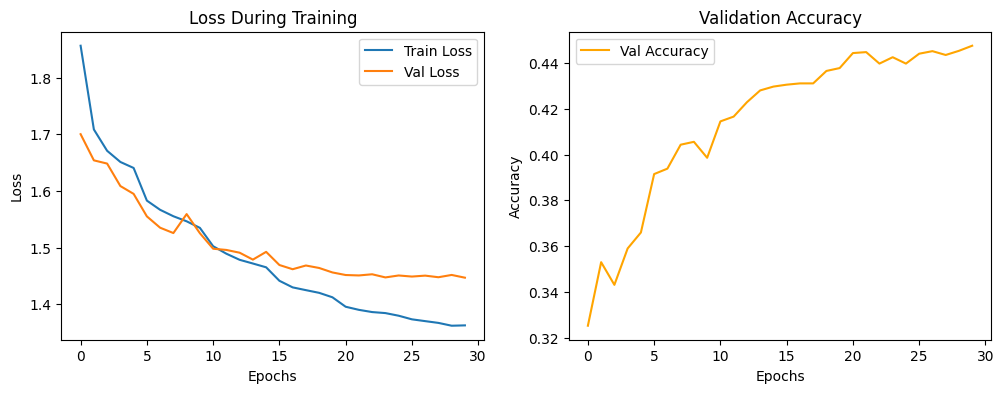

Model weights saved to /kaggle/working/kan_emotion_model.pth


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# ===================== STEP 1: Define the KAN Layer =====================
class KANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_intervals=10, spline_degree=3, device="cpu"):
        """
        Implements a single layer of the Kolmogorov-Arnold Network (KAN).
        
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output nodes.
            num_intervals (int): Number of intervals for the B-spline.
            spline_degree (int): Degree of the B-spline.
            device (str): Device for computation ("cpu" or "cuda").
        """
        super(KANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_intervals = num_intervals
        self.spline_degree = spline_degree
        self.device = device

        # Initialize the spline grid and coefficients
        self.grid = torch.linspace(-1, 1, num_intervals + 1).repeat(input_dim, 1).to(device)
        self.spline_coeffs = nn.Parameter(
            torch.randn(num_intervals + spline_degree, input_dim, output_dim).to(device)
        )
        
        # Fully connected weights for output combination
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Forward pass through the KAN Layer."""
        processed_features = []
        
        # Process each input feature through its B-spline
        for i in range(self.input_dim):
            feature = x[:, i]
            spline_output = self.evaluate_splines(feature, self.grid[i], self.spline_coeffs[:, i, :])
            processed_features.append(spline_output)
        
        # Stack and pass through a fully connected layer
        preprocessed_data = torch.stack(processed_features, dim=1).sum(dim=1)
        return self.fc(preprocessed_data)

    @staticmethod
    def evaluate_splines(x, grid, coeffs):
        """ Evaluate the B-spline basis functions."""
        degree = coeffs.size(0) - (grid.size(0) - 1)
        spline_output = torch.zeros(x.size(0), coeffs.size(1), device=x.device)
        
        # Polynomial approximation of splines
        for d in range(degree):
            spline_output += coeffs[d] * (x.unsqueeze(1) ** d)
        
        return spline_output

# ===================== STEP 2: Load and Prepare Dataset =====================
def load_fer2013_folders(data_path):
    """Load FER2013 dataset organized into folders by class."""
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=transform)
    val_dataset = datasets.ImageFolder(root=f"{data_path}/test", transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]))
    return train_dataset, val_dataset

# ===================== STEP 3: Define the Full KAN Model =====================
class FullKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullKAN, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)  # Input projection layer
        self.layer1 = KANLayer(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.input_projection(x)  # Reduce input dimension to hidden_dim
        x = torch.relu(x)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = torch.relu(x)
        return self.layer3(x)

# ===================== STEP 4: Training and Visualization =====================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    """ Train the model and visualize training progress."""
    train_losses, val_losses, val_accuracies = [], [], []
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.view(images.size(0), -1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Step scheduler for learning rate adjustment
        scheduler.step()

        # Validation phase
        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images.view(images.size(0), -1))
                val_loss += criterion(outputs, labels).item() * images.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss During Training')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

    # Save the model weights
    torch.save(model.state_dict(), "/kaggle/working/kan_emotion_model.pth")
    print("Model weights saved to /kaggle/working/kan_emotion_model.pth")

# ===================== STEP 5: Main Execution =====================
if __name__ == "__main__":
    # Path to FER2013 dataset folders
    data_path = "/kaggle/input/fer2013"  # Root path containing train/test folders

    # Load datasets from folders
    train_dataset, val_dataset = load_fer2013_folders(data_path)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Model, optimizer, scheduler, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FullKAN(input_dim=48*48, hidden_dim=256, output_dim=7).to(device)  # 7 emotion classes
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)
